# Quality Control (QC) Pipeline

In [1]:
import methylcheck
from pathlib import Path # a tidier (pythonic) way to refer to files and folder paths

Previously, you need to process a batch of IDAT files using `methylprep`. The command line interface command for this is the following:
```
python -m methylprep process -d . --all
```
The `.` means the current folder, so you have to navigate to the current folder for this `process` command, or supply the path.
This creates a bunch of new python pickle `.pkl` files in the folder:

```
beta_values.pkl
poobah_values.pkl
control_probes.pkl
m_values.pkl
noob_meth_values.pkl
noob_unmeth_values.pkl
sample_sheet_meta_data.pkl
```
`methylcheck`'s QC functions use these files.

## To load beta values:

In [2]:
filepath = Path('/Volumes/methylation/')
df = methylcheck.load(filepath)
print(df.shape)
# where the first argument is the path or file you want to load. This also works, 
# if you start your jupyter notebook in the same folder
df = methylcheck.load(Path(filepath,'beta_values.pkl'))
# by default, probes that failed p-value detection are removed from the dataframe, unless you used the `--no_poobah` option during processing.
print(df.shape)
# Just noting that you get the same thing whether you specify the file path or the specific file name.

Files: 100%|██████████| 1/1 [00:00<00:00, 35.83it/s]
INFO:methylcheck.load_processed:loaded data (226618, 1) from 1 pickled files (0.05s)
Files:   0%|          | 0/1 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
Files: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]
INFO:methylcheck.load_processed:loaded data (226618, 1) from 1 pickled files (0.271s)


(226618, 1)
(226618, 1)


## Quality Control Plots
There are 3 QC functions you can use to generate a set of plots.
### ``methylcheck.run_qc()``

1 - `methylcheck.run_qc()` is fhe first, most basic function.

It will generate a set of QC plots in a notebook, in interpreter, or command line, but doesn't allow for any customization. You only supply the path to the methylprep output files. 

Note that the `run_qc()` function requires you to specify a path to the output files, and not just pass in a dataframe
of beta values, because it looks at control probes too.

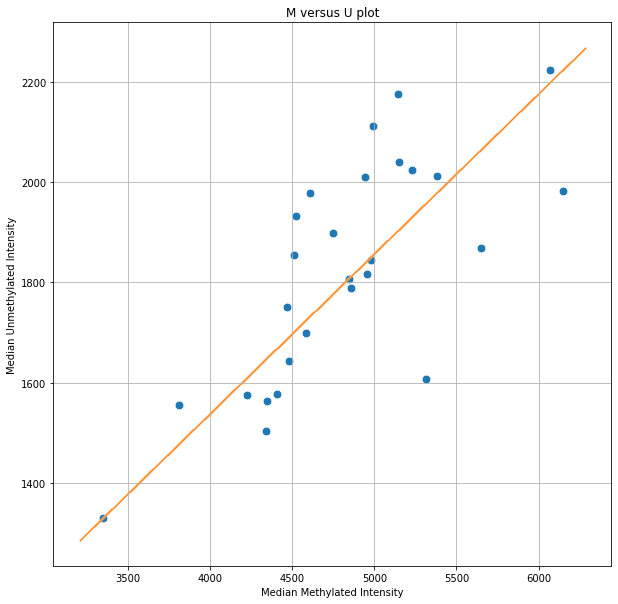

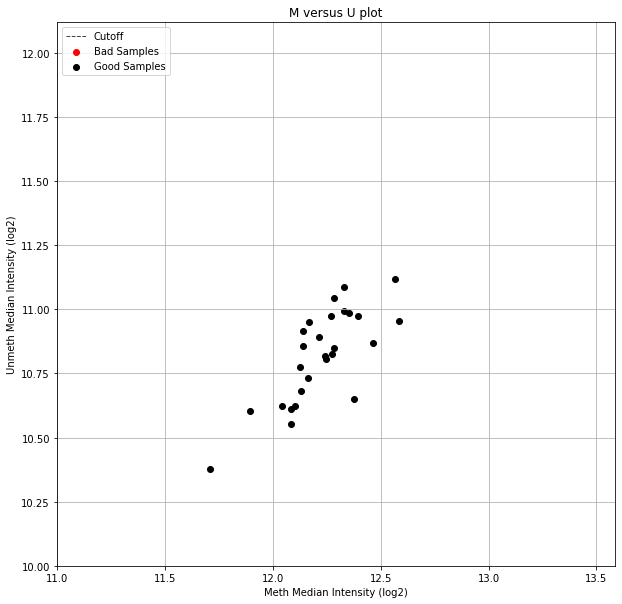

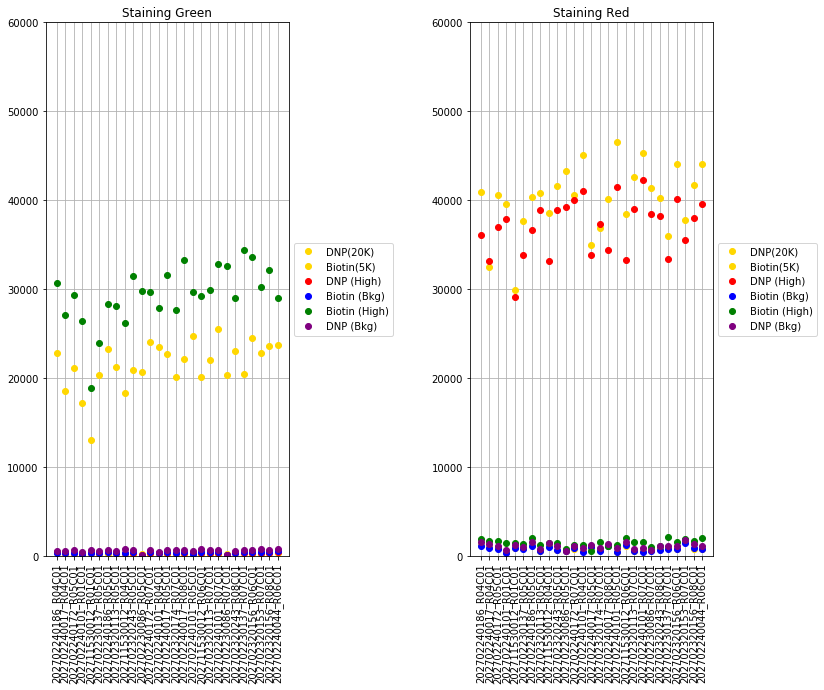

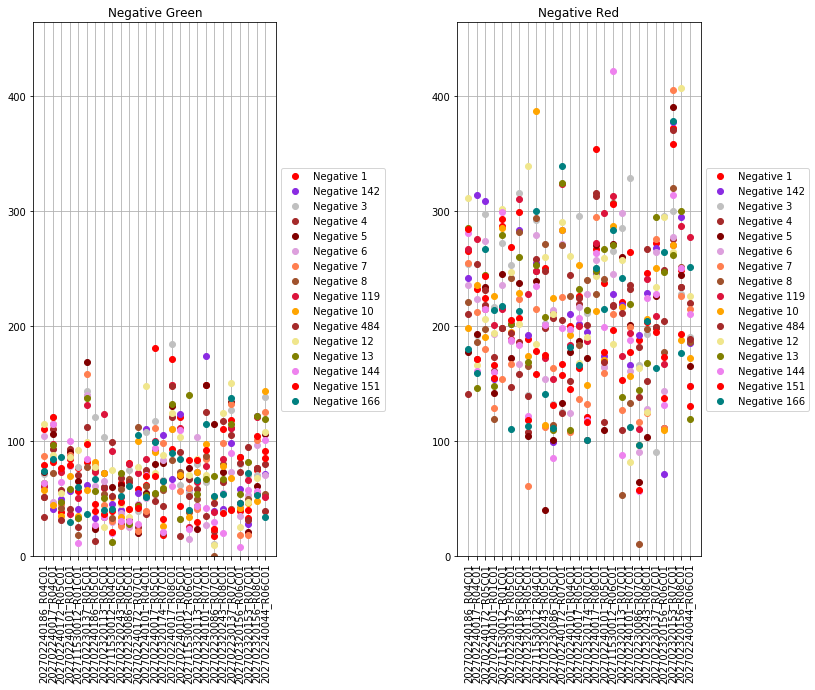

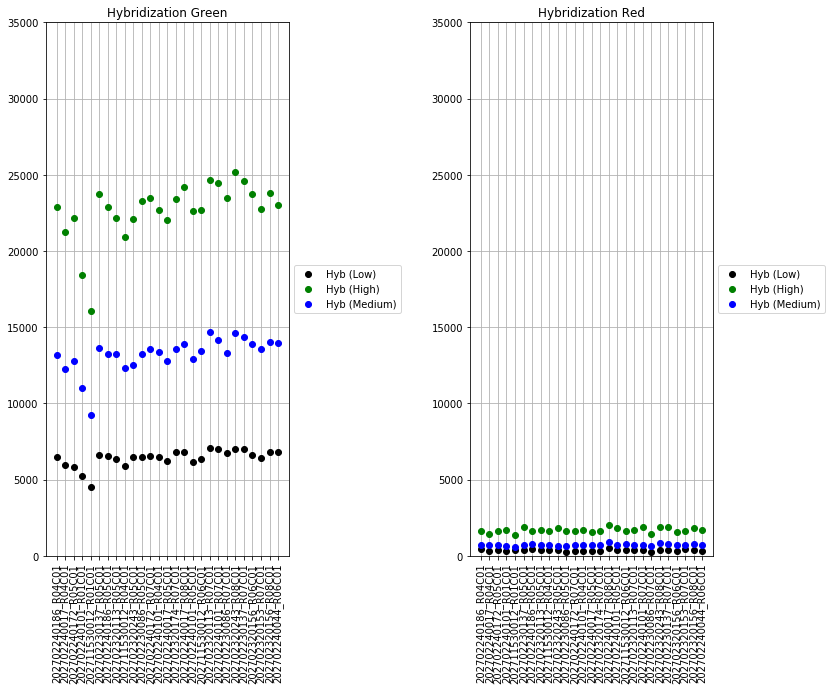

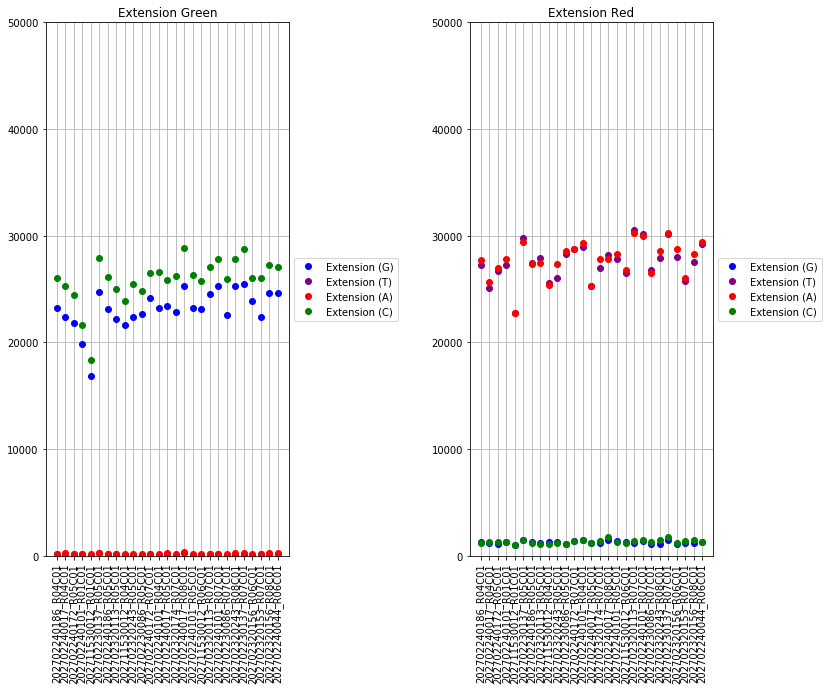

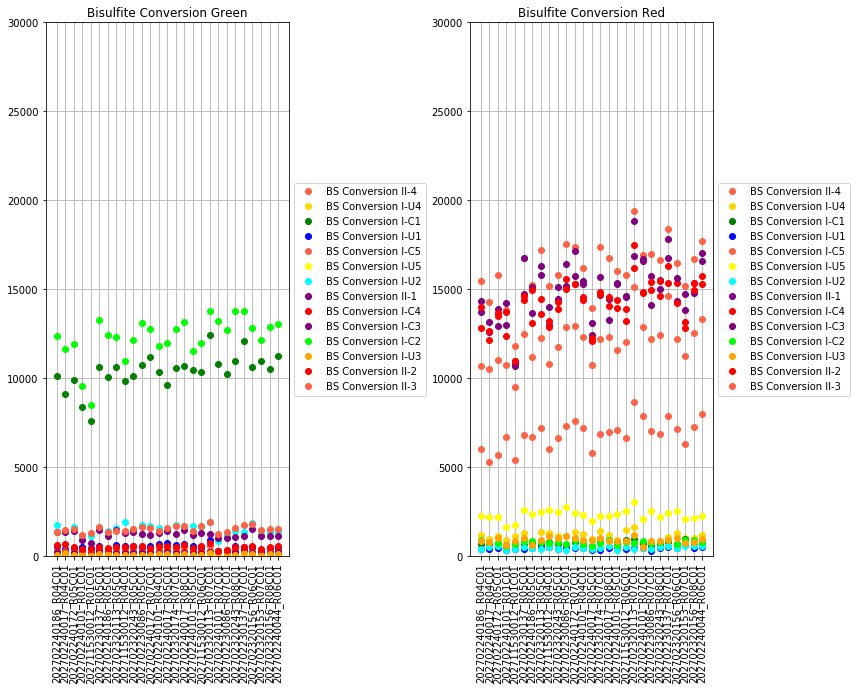

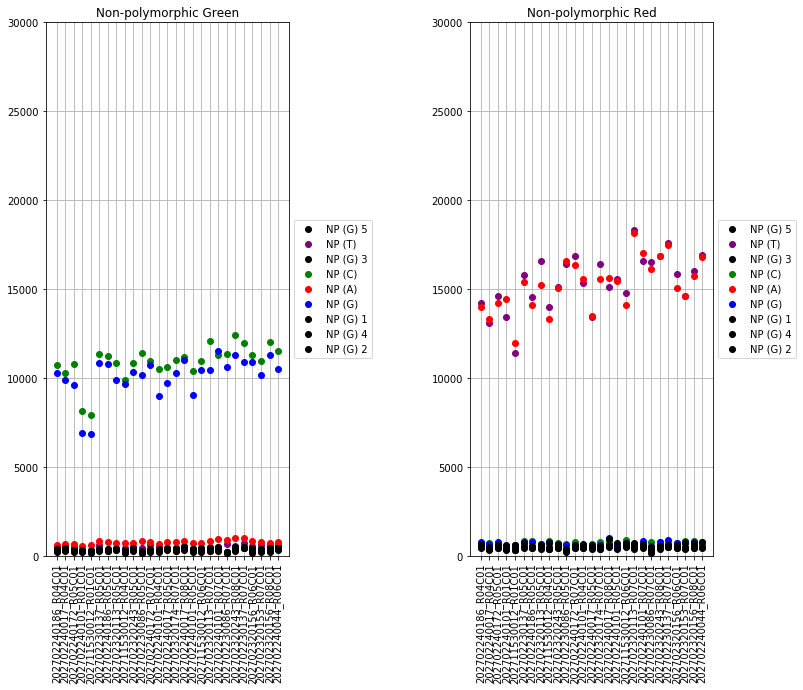

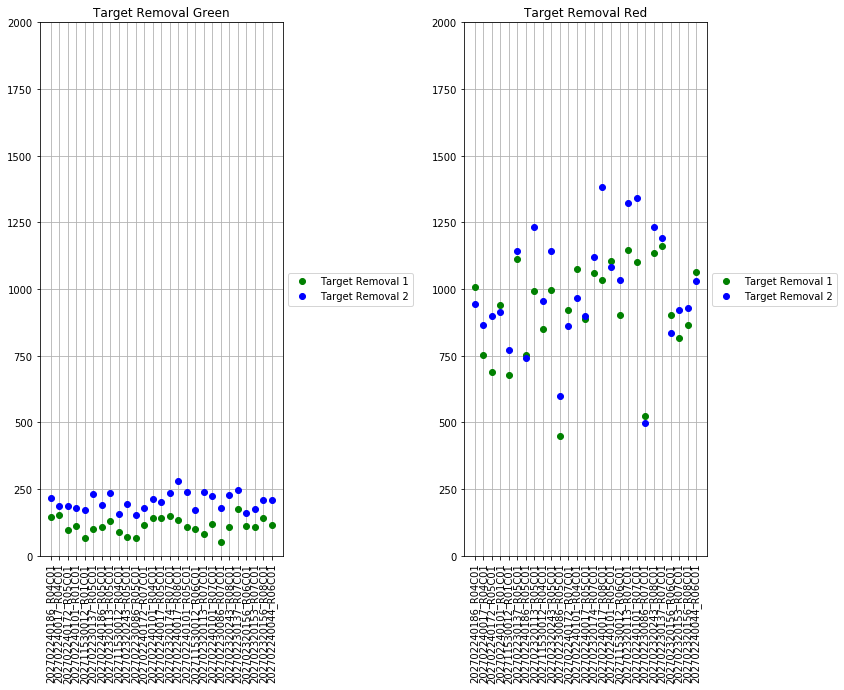

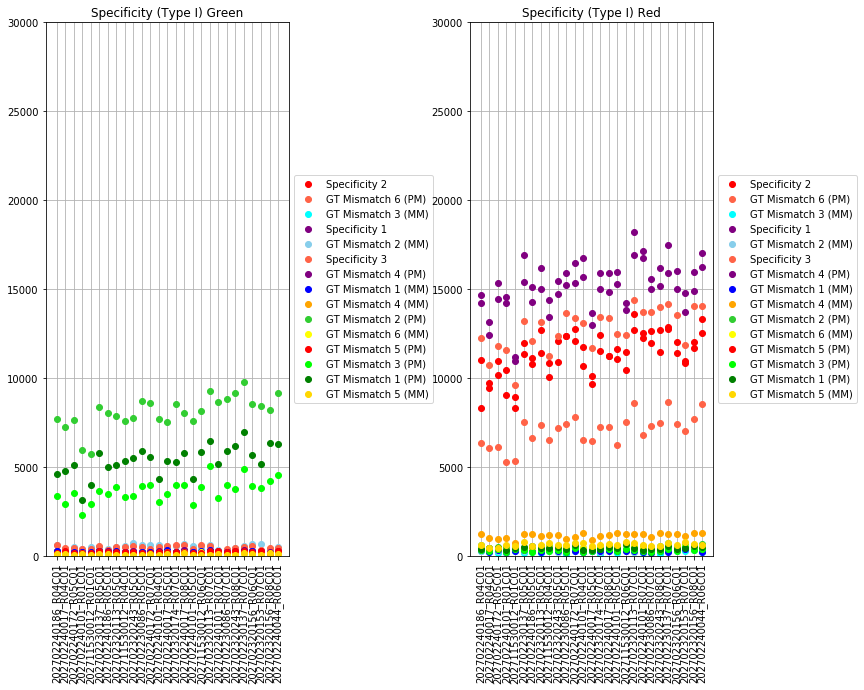

INFO:methylprep.files.manifests:Reading manifest file: MethylationEPIC_v-1-0_B4.CoreColumns.csv


Found 142137 type I probes.


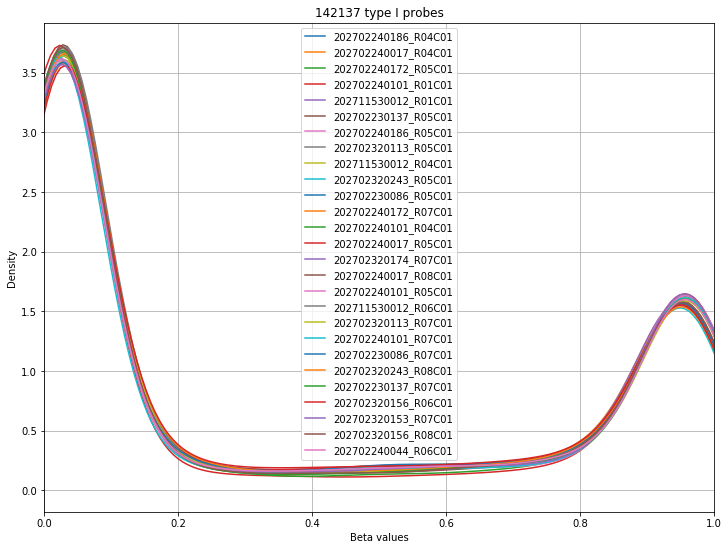

Found 723722 type II probes.


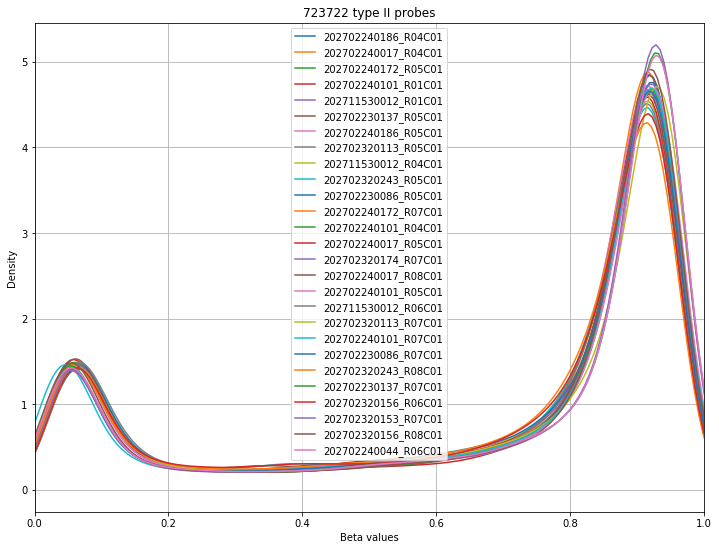

Found 92198 type I Red (IR) probes.


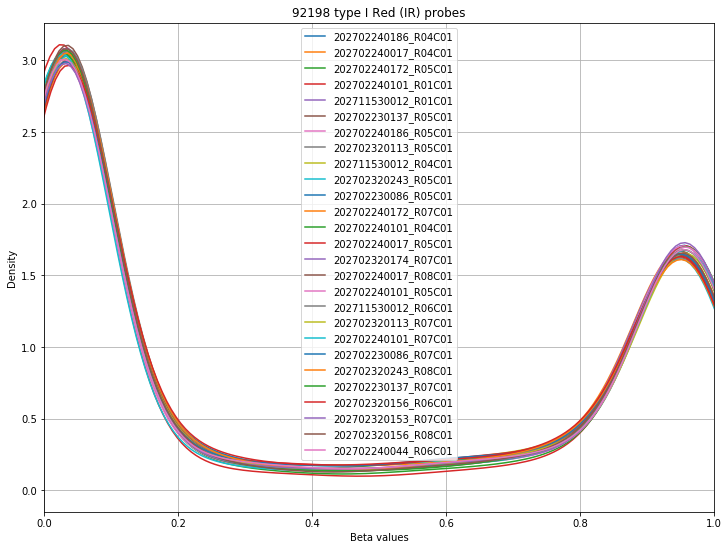

Found 49939 type I Green (IG) probes.


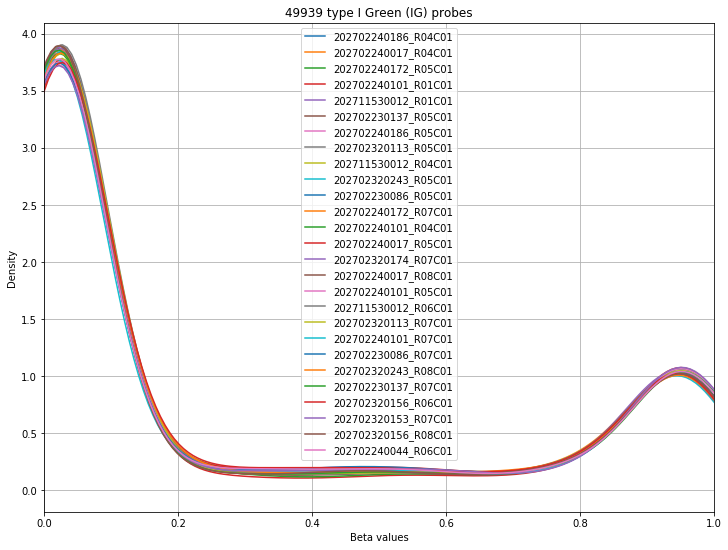

In [3]:
filepath = Path('/Volumes/LEGX/geo_test2/GSE125367')
methylcheck.run_qc(filepath)

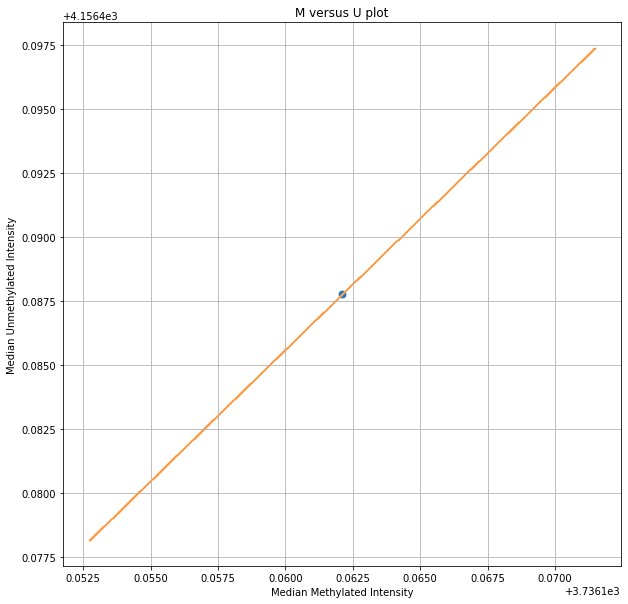

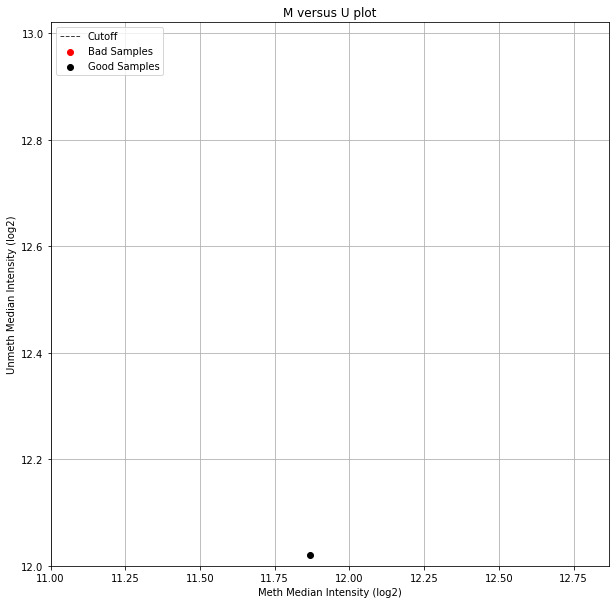

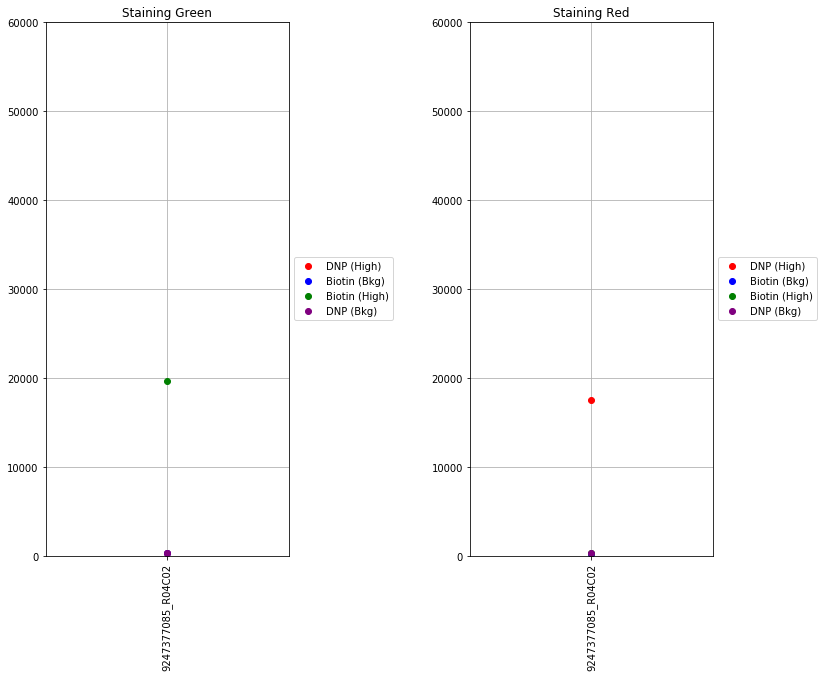

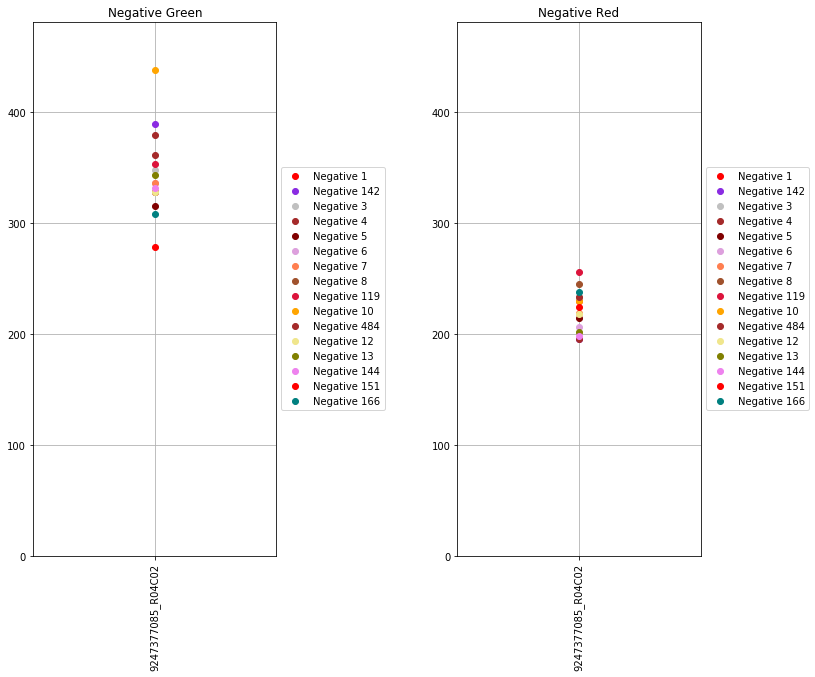

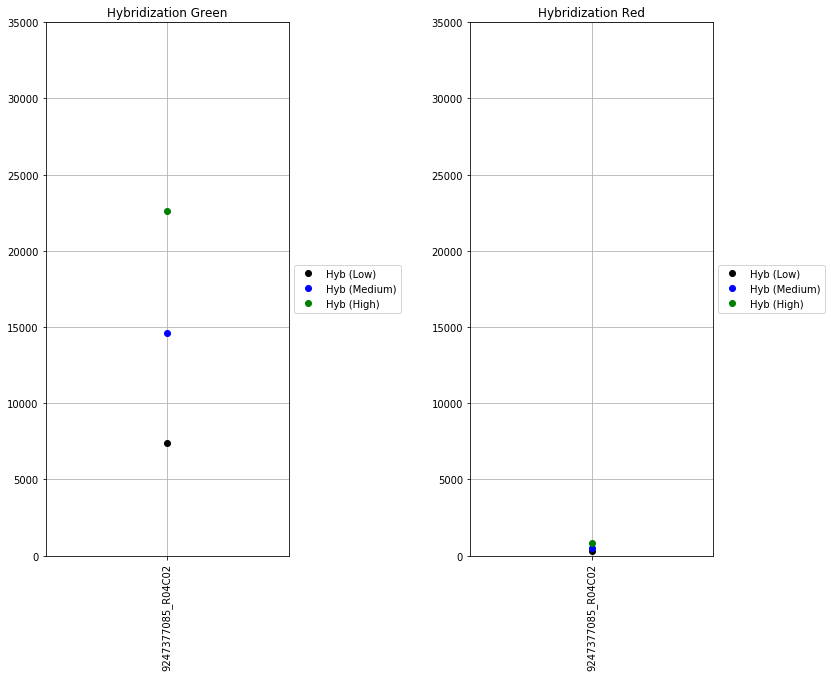

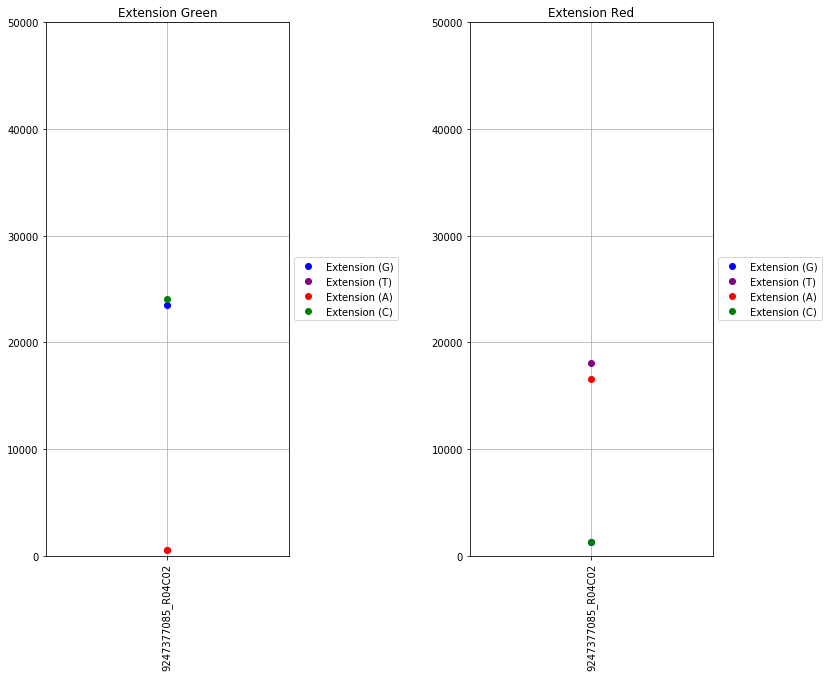

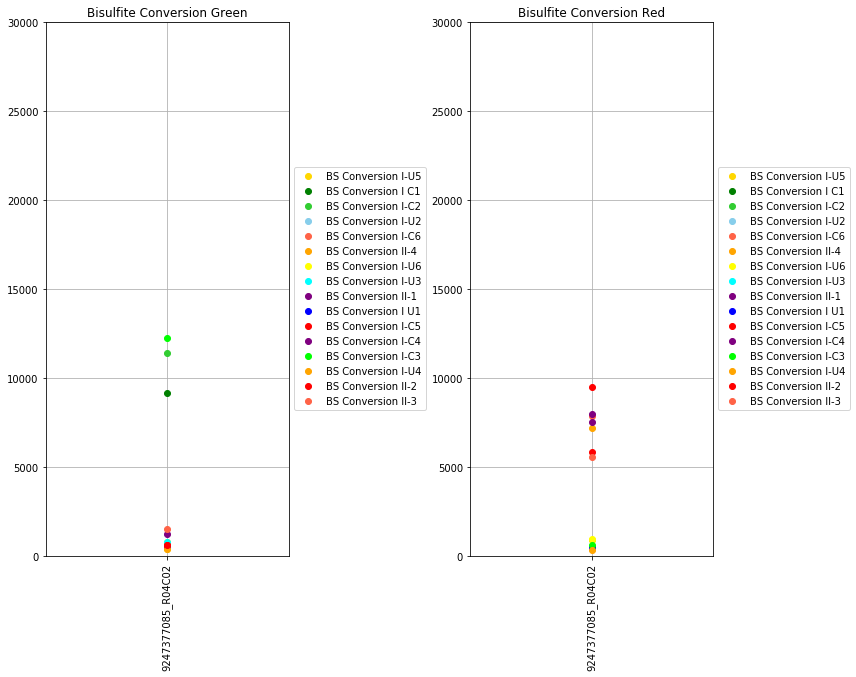

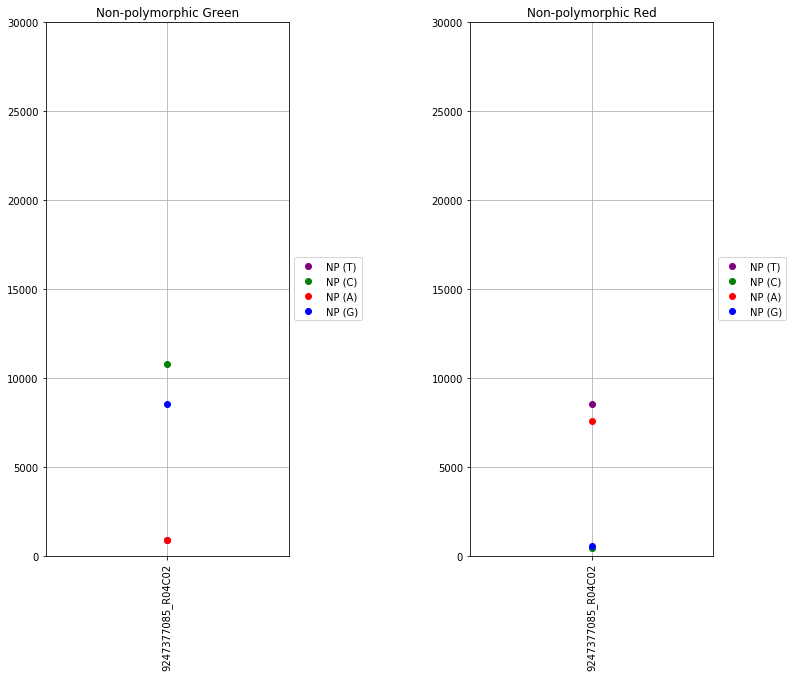

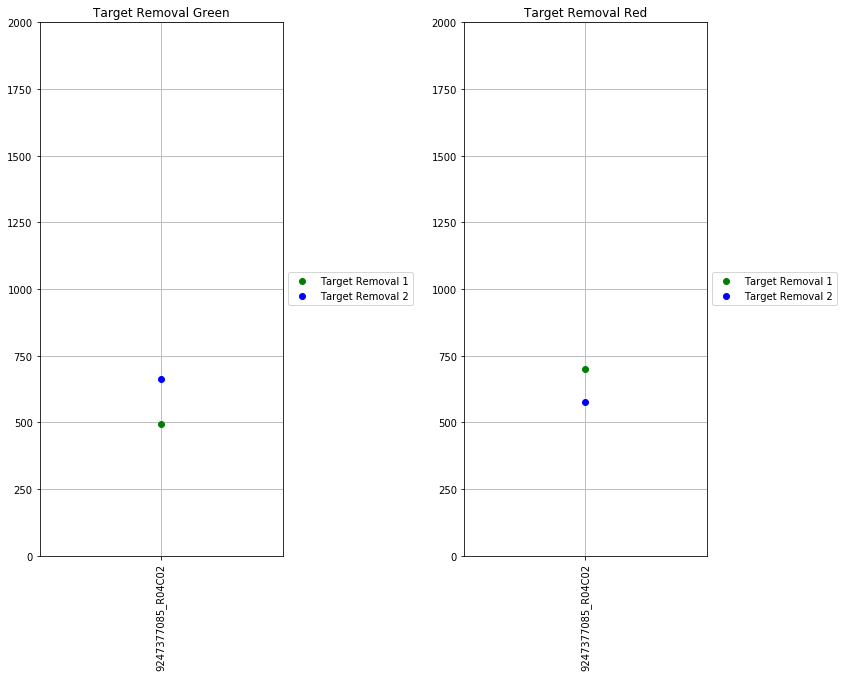

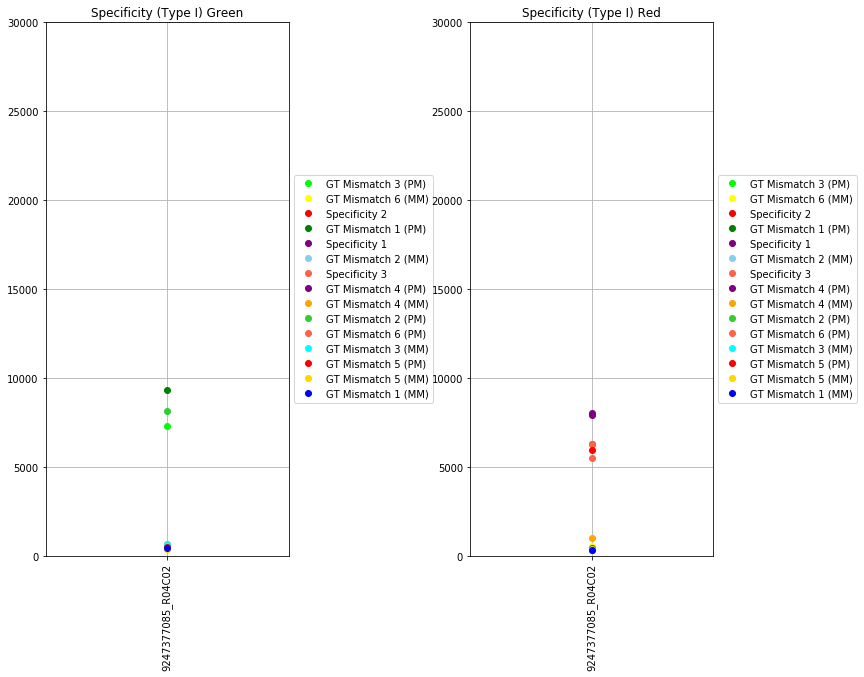

INFO:methylprep.files.manifests:Reading manifest file: HumanMethylation450_15017482_v1-2.CoreColumns.csv


Found 135476 type I probes.


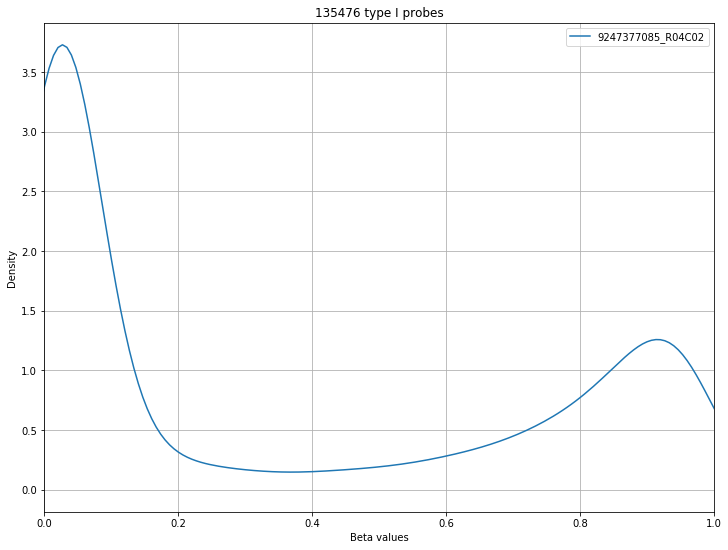

Found 350036 type II probes.


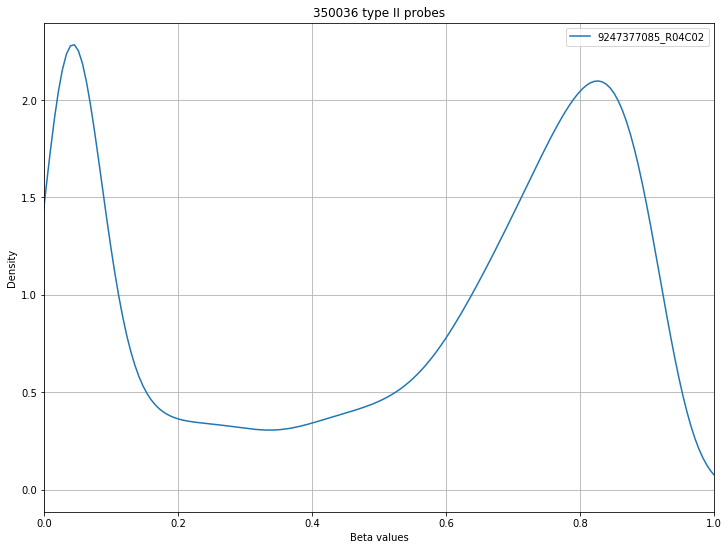

Found 89187 type I Red (IR) probes.


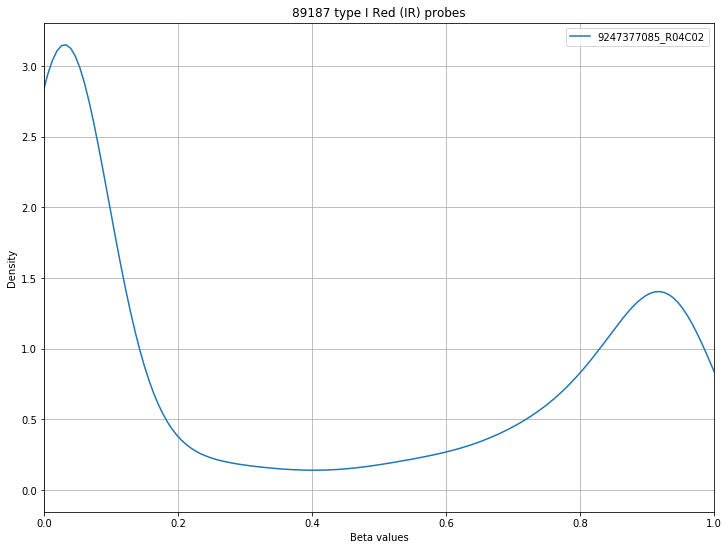

Found 46289 type I Green (IG) probes.


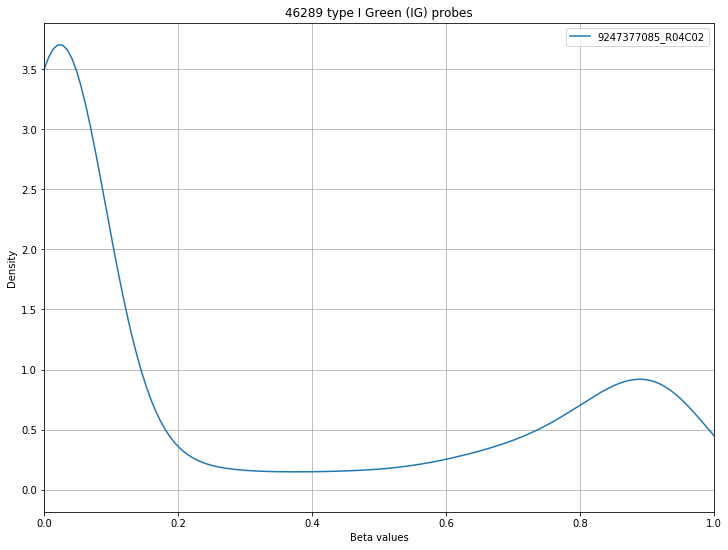

In [4]:
# this test data is included with methylprep, if you want to try it.
filepath = Path('~/methylcheck/docs/example_data/GSE69852')
methylcheck.run_qc(filepath)

Second, `methylcheck` includes a more extensive and interactive quality control pipeline under the function `methylcheck.run_pipeline`. See this page for details on that:
[ReportPDF](https://life-epigenetics-methylcheck.readthedocs-hosted.com/en/feature-mouse/docs/source/modules.html#module-methylcheck.qc_report.ReportPDF)

Finally, `methylcheck` includes a PDF Report creating tool `methylcheck.qc_report.ReportPDF` that you can use to specify exactly what goes into the QC report. This lets you set pass/fail criteria and embed customized charts, and is more of a programmable report making tool, meant for use in an automated lab processing context.

## Report PDF tool
- This is the fully customizable class template for making more advanced quality control reports
- this will call a batch of plotting functions and compile a PDF with annotation and save file to disk
- kwargs: filename, poobah_max_percent, pval_cutoff,
- title, author, subject, keywords, outpath, path

In [6]:
my_report = methylcheck.qc_report.ReportPDF(filename='some_file_name.pdf', 
                                            title="Report Title",
                                            path=Path('~/methylcheck/docs/example_data/GSE69852'))

In [7]:
my_report.run_qc()

INFO:methylcheck.qc_report:Data loaded
INFO:methylcheck.qc_report:Beta Density Plot
INFO:methylcheck.qc_report:Poobah: 0 failure(s) out of 1 samples.
INFO:methylcheck.qc_report:Beta MDS Plot
/Users/mmaxmeister/methylcheck/methylcheck/samples/postprocessQC.py:517: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim([x_range_min, x_range_max])
/Users/mmaxmeister/methylcheck/methylcheck/samples/postprocessQC.py:518: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([y_range_min, y_range_max])
INFO:methylcheck.qc_report:M_vs_U plot
INFO:methylcheck.qc_report:QC signal intensity plot
INFO:methylcheck.qc_report:Control probes
INFO:methylcheck.qc_report:Betas by probe type
INFO:methylprep.files.manifests:Reading manifest file: HumanMethylation450_15017482_v1-2.CoreColumns.csv


In [8]:
# Once everything has been added, you need to close the PDF before you can read it on disk.
my_report.pdf.close()
# look in the path folder for a PDF file called "some_file_name.pdf" -- it will be similar to the charts 
# returned by methylprep.run_qc()

#### You can customize your ReportPDF and even pass in customized tables like this:

```
    # generate report
    report = methylcheck.qc_report.ReportPDF(
        path=working.name,
        poobah_max_percent=10,
        pval_cutoff=0.01,
        title='QC Report',
        author='FOXO Biosciences',
        subject="QC Report",
        keywords="methylation array",
        outpath=working.name,
        filename=report_filename,
        poobah=True,
        on_lambda=True,
        custom_tables=custom_tables,
        debug=True,
        order=['beta_density_plot', 'mds', 'auto_qc',        
            'M_vs_U', 'qc_signal_intensity', 'controls',
            'probe_types'],
    )
    report.run_qc()
    report.pdf.close()
```

#### Notes:
- 'on_lambda': if you are running this within an AWS lambda function in the cloud, the default paths of your manifest and other files will change. When True, `on_lambda` will allow you to specify and override paths to your intput, output, and manifest files.
- 'path': where to read files from.
- 'outpath': in this example, `working.name` is a python `tempdir` folder in a lambda virtual environment. Everything is processed there but saved by moving to an S3 bucket. 
- 'poobah': whether the QC should run on samples that have failed probes removed (recommended)
- custom_tables: passing in additional tables to the report. See the function's help for more details (e.g. `help(methylcheck.qc_report.ReportPDF)`).
- 'order': Option to specify the order of charts in the REPORT.